In [1]:
#import rosbag
import rospy
import numpy as np
import matplotlib.pyplot as plt
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import cv2
import os
from ultralytics import YOLO
import rosbag

/Users/nicoloagostara/miniforge3/envs/ros_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bag_path = "../../../bags/heron_scene1.bag"
bag = rosbag.Bag(bag_path)

In [3]:
#get bags topics
topics = bag.get_type_and_topic_info()

for topic in topics.topics:
    print(topic)

/b_raw_scan
/b_scan
/b_scan_rep117
/f_raw_scan
/f_scan
/f_scan_rep117
/imu_data
/odom
/odom_enc
/realsense/align_to_color/parameter_descriptions
/realsense/aligned_depth_to_color/camera_info
/realsense/aligned_depth_to_color/image_raw
/realsense/depth/camera_info
/realsense/depth/image_raw
/realsense/depth/metadata
/realsense/depth/points
/realsense/extrinsics/depth_to_rgb
/realsense/pointcloud/parameter_descriptions
/realsense/pointcloud/parameter_updates
/realsense/rgb/camera_info
/realsense/rgb/image_raw
/robot_pose
/robot_state
/scan
/tf
/tf_rss
/tf_static
/tf_static_rss


In [4]:
import supervision as sv
model = YOLO("../models/yolov8l-seg.pt")
model = model.to("mps")

In [5]:
target = 62
data = []

In [6]:
names = model.names
names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [7]:
bridge = CvBridge()
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()
image = np.ones((480, 640 * 2, 3), dtype=np.uint8) * 255
detections = None
for i, (topic, msg, t) in enumerate(
    bag.read_messages(
        topics=[
            "/realsense/rgb/image_raw",
            "/realsense/aligned_depth_to_color/image_raw",
        ]
    )
):
    if i < 2000:
        continue
    if topic == "/realsense/rgb/image_raw":
        img = bridge.imgmsg_to_cv2(msg, desired_encoding="bgr8")
        results = next(
            model.track(
                img,
                device="cpu",
                stream=True,
                persist=True,
                verbose=False,
                tracker="bytetrack.yaml",
            )
        )
        if results:
            detections = sv.Detections.from_ultralytics(results)
            if (
                not detections
                or detections.data["class_name"] is None
                or detections.tracker_id is None
            ):  
                labels = []
                img = label_annotator.annotate(img, detections)
            else:
                labels = [
                    f"{tracker_id}:{class_name}"
                    for class_name, tracker_id in zip(
                        detections.data["class_name"], detections.tracker_id
                    )
                ]
                # keep only the first backpack
                img = label_annotator.annotate(img, detections, labels=labels)
            img = mask_annotator.annotate(img, detections)

        image[:, :640, :] = img
    elif topic == "/realsense/aligned_depth_to_color/image_raw":
        depth = bridge.imgmsg_to_cv2(msg, desired_encoding="passthrough")
        depth_map = np.array(depth, dtype=np.float32)
        depth = depth_map / 9000
        depth = 255 - (depth * 255)
        depth = np.array(depth, dtype=np.uint8)
        # annoatte depth
        depth = np.array([depth, depth, depth]).transpose(1, 2, 0)
        if detections is not None:
            depth = mask_annotator.annotate(depth, detections)
        image[:, 640:, :] = depth

    cv2.imshow("image", image)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
    if key == ord("s"):
        data.append((image, depth_map, detections))
        print("Saved")


cv2.destroyAllWindows()

Saved
Saved


In [8]:
len(data)

1

In [10]:
img, depth, detections = data[0]


(-0.5, 1279.5, 479.5, -0.5)

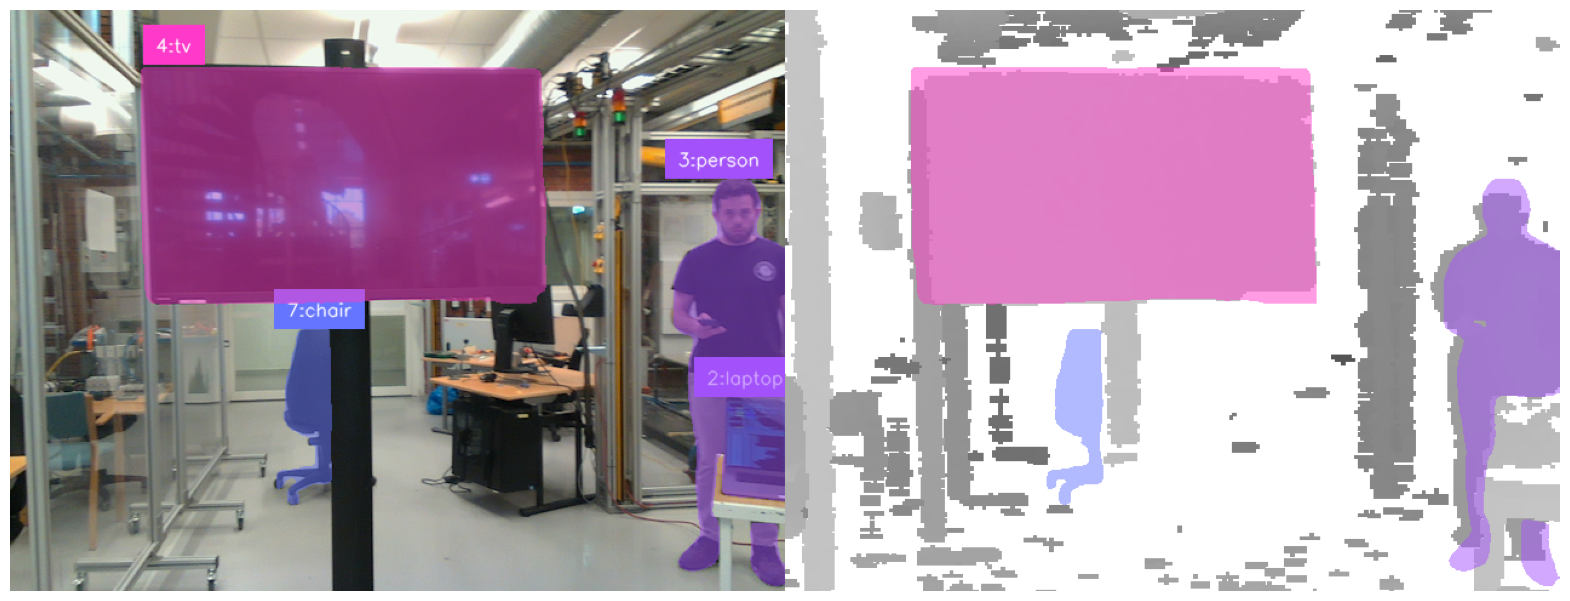

In [11]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")

In [12]:
def extract_mask(detections, label = "tv", get_binary = True):
    mask = np.zeros((480, 640, 3)).astype(np.uint8)
    for det in detections:
        if det[-1]["class_name"] == label:
            xmin, ymin, xmax, ymax = det[0].astype(int) 
            if get_binary:
                mask[det[1]] = 1 
            else:
                mask[det[1]] = (0, 128, 128)
                cv2.putText(mask, label, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            break
    return mask

In [13]:
def compute_pointcloud(depth_image, mask):
    pc = depth_image * mask
    (ys, xs) = np.argwhere(pc).T

    # remove from the pointcloud the points that are too close or too far from the camera
    zs = pc[ys, xs] / 1000
    mask = np.logical_and(zs > 1, zs < 9)
    ys = ys[mask]
    xs = xs[mask]
    zs = zs[mask]

    pointcloud = np.array([xs, ys, zs]).T

    return pointcloud

(480, 640) (480, 640)


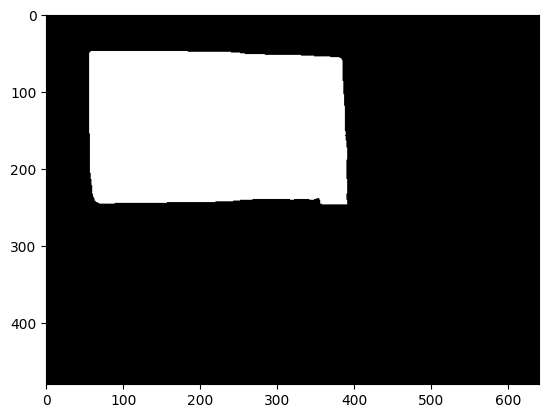

In [14]:
mask = extract_mask(detections, "tv")
print(depth.shape, mask[..., 0].shape)
pc = compute_pointcloud(depth, mask[..., 0])
mask *= 255
plt.imshow(mask)

In [15]:
K = np.array([[602.9169921875, 0.0, 326.9552001953125],[0.0, 602.666748046875, 238.95875549316406], [0.0, 0.0, 1.0]])
K_inv = np.linalg.inv(K)
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]

In [16]:
uv = pc[:, :2]
uv = np.concatenate([uv, np.ones((uv.shape[0], 1))], axis = 1)
pc3d = K_inv @ uv.T
pc3d[2] = pc[:, 2]
pc3d = pc3d.T
pc3d

array([[   -0.31174,    -0.31686,        5.13],
       [   -0.31008,    -0.31686,        5.13],
       [   -0.30843,    -0.31686,        5.13],
       ...,
       [   -0.39965,    0.010024,        3.72],
       [   -0.39799,    0.010024,        3.72],
       [   -0.39633,    0.010024,        3.72]])

In [17]:
u, v = pc[:, :2].T

Z = pc[:, 2]
X = (u - cx) * pc[:, 2] / fx
Y = (v - cy) * pc[:, 2] / fy

pc3d = np.array([X, Y, Z]).T
pc3d.shape

(60406, 3)

In [18]:
pc3d.min(axis = 0), pc3d.max(axis = 0)  

(array([    -1.6607,     -1.6755,       2.037]),
 array([    0.23778,    0.041473,        5.43]))

In [19]:
pc3d = pc3d[pc3d[:, 1] > -0.7]
pc3d

array([[    -0.6791,    -0.65487,       2.111],
       [    -0.6756,    -0.65487,       2.111],
       [   -0.67209,    -0.65487,       2.111],
       ...,
       [    -1.4867,     0.03729,        3.72],
       [    -1.4805,     0.03729,        3.72],
       [    -1.4744,     0.03729,        3.72]])

In [20]:
general_points_color = np.array([0.392, 0.392, 0.392])  # Dark Gray
outlier_color = np.array([0.6, 0.0, 0.2])              # Dark Crimson Red
gt_point_color = np.array([0.0, 0.392, 0.0])           # Forest Green
box_color = np.array([0.0, 0.2, 0.6]) 

In [21]:
import open3d as o3d
from compas.geometry import oriented_bounding_box_numpy
pcd = o3d.geometry.PointCloud()
box_points = oriented_bounding_box_numpy(pc3d)

obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(box_points))
#obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(pc3d))
obb.color = box_color

In [22]:
pcd.points = o3d.utility.Vector3dVector(pc3d)
o3d.visualization.draw_geometries(
    [pcd, obb],
    front=[-0.54689304503484815, -0.07483384388939826, -0.83385124159003854],
    lookat=[-0.20045206185551434, -0.2346543824952167, 2.3173025365603173],
    up=[-0.0097985230668723479, -0.99535674019842613, 0.095754627497947747],
    zoom=0.17319999999999983,
)
pcd

PointCloud with 59878 points.

In [23]:
def get_rotation_matrix_from_vectors(vec1, vec2):
    """Compute the rotation matrix that aligns vec1 to vec2."""
    a = vec1 / np.linalg.norm(vec1)
    b = vec2 / np.linalg.norm(vec2)
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2 + 1e-10))
    return rotation_matrix

def create_cylinder_line(start, end, radius=0.01, resolution=20, color = [0, 1, 0]):
    # Calculate the direction and length of the cylinder
    direction = end - start
    length = np.linalg.norm(direction)
    direction /= length

    # Create cylinder and rotate it to align with the direction
    cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius, length, resolution=resolution)
    cylinder.paint_uniform_color(color)
    cylinder.compute_vertex_normals()
    mid_point = (start + end) / 2
    cylinder.translate(mid_point)
    # Calculate rotation matrix to align cylinder with direction vector
    z_axis = np.array([0, 0, 1])
    rotation_matrix = get_rotation_matrix_from_vectors(z_axis, direction)
    cylinder.rotate(rotation_matrix, center=mid_point)

    return cylinder

def add_bounding_box_with_thick_lines(obb, line_radius=0.01):
    # Extract 8 corners of the Oriented Bounding Box (OBB)
    corners = np.asarray(obb.get_box_points())

    # Define pairs of corner indices that form the edges
    edges = [
        [0, 1],
        [1, 7],
        [7, 2],
        [2, 0],  # Bottom face
        [3, 6],
        [6, 4],
        [4, 5],
        [5, 3],  # Top face
        [0, 3],
        [1, 6],
        [2, 5],
        [7, 4],  # Vertical edges connecting top and bottom
    ]

    # Add each edge as a cylinder
    box_meshes = []
    for edge in edges:
        start, end = corners[edge[0]], corners[edge[1]]
        cylinder = create_cylinder_line(start, end, radius=line_radius, color = obb.color)
        box_meshes.append(cylinder)
    
    return box_meshes

def save_scene(pcd, box, outliers = None, radius = 0.01):
    mesh = o3d.geometry.TriangleMesh()
    for point in pcd.points:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
        sphere.compute_vertex_normals()
        sphere.paint_uniform_color(gt_point_color)
        sphere.translate(point)
        mesh += sphere
    
    if outliers is not None:
        for point in outliers:
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
            sphere.compute_vertex_normals()
            sphere.paint_uniform_color(outlier_color)
            sphere.translate(point)
            mesh += sphere
    
    box_meshes = add_bounding_box_with_thick_lines(box)
    for box_mesh in box_meshes:
        mesh += box_mesh
    
    #o3d.visualization.draw_geometries([mesh])
    return mesh

pcd = pcd.voxel_down_sample(voxel_size=0.02)
mesh = save_scene(pcd, obb)
o3d.visualization.draw_geometries([mesh])
o3d.io.write_triangle_mesh("noisy_pred.glb", mesh)

True

In [24]:
pcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries(
    [pcd, obb],
    front=[-0.54689304503484815, -0.07483384388939826, -0.83385124159003854],
    lookat=[-0.20045206185551434, -0.2346543824952167, 2.3173025365603173],
    up=[-0.0097985230668723479, -0.99535674019842613, 0.095754627497947747],
    zoom=0.17319999999999983,
)
pcd

mesh = save_scene(pcd, obb)
o3d.visualization.draw_geometries([mesh])
o3d.io.write_triangle_mesh("downsampled_pred.glb", mesh)

True

In [28]:
#_, out = pcd.remove_radius_outlier(nb_points=50, radius=0.5)
#clean = pcd.select_by_index(out)
outliers = np.asarray(pcd.select_by_index(out, invert=True).points)
_, out2 = clean.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.8)
clean = clean.select_by_index(out2)
clean.paint_uniform_color(gt_point_color)


out2 = np.asarray(clean.select_by_index(out2, invert=True).points)
outliers = np.concatenate([outliers, out2], axis = 0)
outliers_pcd = o3d.geometry.PointCloud()
outliers_pcd.points = o3d.utility.Vector3dVector(outliers)
outliers_pcd.paint_uniform_color(outlier_color)

box_points = oriented_bounding_box_numpy(np.asarray(clean.points))
obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(box_points))
obb.color = box_color
o3d.visualization.draw_geometries(
    [outliers_pcd, clean, obb],
    front=[-0.54689304503484815, -0.07483384388939826, -0.83385124159003854],
    lookat=[-0.20045206185551434, -0.2346543824952167, 2.3173025365603173],
    up=[-0.0097985230668723479, -0.99535674019842613, 0.095754627497947747],
    zoom=0.17319999999999983,
)


In [29]:
mesh = save_scene(clean, obb, outliers = outliers)
o3d.visualization.draw_geometries([mesh])

In [30]:
o3d.io.write_triangle_mesh("cleaned_pred.glb", mesh)

True

In [89]:
o3d.visualization.draw_geometries([outliers_pcd])

In [1]:
def create_grid_and_calculate_iou(pred_points, gt_points, grid_size=0.1):
    """
    Create a 3D grid (cube) and calculate the Intersection over Union (IoU) for two point clouds.

    Parameters:
    - pred_points: numpy array of shape (N, 3) for predicted point cloud.
    - gt_points: numpy array of shape (N, 3) for ground truth point cloud.
    - grid_size: The size of each cell in the 3D grid (e.g., 0.05 meters).

    Returns:
    - IoU: Intersection over Union value.
    """
    # Compute grid indices based on absolute coordinates
    pred_indices = np.floor(pred_points / grid_size).astype(np.int32)
    gt_indices = np.floor(gt_points / grid_size).astype(np.int32)

    # Convert grid indices to sets of tuples for efficient comparison
    pred_set = set(map(tuple, pred_indices))
    gt_set = set(map(tuple, gt_indices))

    # Compute intersection and union
    intersection = pred_set & gt_set
    union = pred_set | gt_set

    iou = len(intersection) / len(union) if len(union) > 0 else 0.0
    dice = 2 * len(intersection) / (len(pred_set) + len(gt_set)) if len(pred_set) + len(gt_set) > 0 else 0.0
    return iou, dice, pred_set, gt_set

In [2]:
import scipy.ndimage as ndimage
def iou_voxel_grids_with_closing(pred_points, gt_points, voxel_size=0.05):
    def get_voxel_grids(pred_points, gt_points, voxel_size=0.05):
        pred_points = pred_points.copy()
        gt_points = gt_points.copy()
        min_bound = np.minimum(np.min(pred_points, axis=0), np.min(gt_points, axis=0))
        max_bound = np.maximum(np.max(pred_points, axis=0), np.max(gt_points, axis=0))
        pred_points -= min_bound
        gt_points -= min_bound
        grid_shape = np.ceil((max_bound - min_bound) / voxel_size).astype(int)

        pred_grid = np.zeros(grid_shape)
        gt_grid = np.zeros(grid_shape)

        pred_indices = np.floor(pred_points / voxel_size).astype(np.int32)
        gt_indices = np.floor(gt_points / voxel_size).astype(np.int32)

        pred_indices = np.array(list(set(map(tuple, pred_indices))))
        gt_indices = np.array(list(set(map(tuple, gt_indices))))

        pred_grid[pred_indices[:, 0], pred_indices[:, 1], pred_indices[:, 2]] = 1
        gt_grid[gt_indices[:, 0], gt_indices[:, 1], gt_indices[:, 2]] = 1

        return pred_grid, gt_grid

    try:
        pred_grid, gt_grid = get_voxel_grids(pred_points, gt_points, voxel_size)
        structuring_element = np.ones((2, 2, 2))

        # Perform 3D morphological closing (dilation followed by erosion)
        closed_pred_grid = ndimage.binary_closing(pred_grid, structure=structuring_element)
        closed_gt_grid = ndimage.binary_closing(gt_grid, structure=structuring_element)

        pred_points = np.argwhere(closed_pred_grid)
        gt_points = np.argwhere(closed_gt_grid)

        pred_points = set(map(tuple, pred_points))
        gt_points = set(map(tuple, gt_points))

        intersection = pred_points & gt_points
        union = pred_points | gt_points

        iou = len(intersection) / len(union) if len(union) > 0 else 0.0
        dice = 2 * len(intersection) / (len(pred_points) + len(gt_points)) if len(pred_points) + len(gt_points) > 0 else 0.0

        return iou, dice
    except Exception as e:
        print("using voxel grid iou")
        return create_grid_and_calculate_iou(pred_points, gt_points, voxel_size)

In [3]:
import numpy as np
import open3d as o3d

def create_occupancy_grid_visualization_o3d(point_cloud, grid_size=0.1, color = [0, 0, 1]):
    """
    Visualize the occupancy grid for a given point cloud with highlighted occupied cells and black borders using Open3D.

    Parameters:
    - point_cloud: numpy array of shape (N, 3) representing the input point cloud.
    - grid_size: The size of each cell in the 3D grid.

    Returns:
    - None: Opens an Open3D visualization window.
    """

    # Compute grid indices for the point cloud
    grid_indices = np.floor(point_cloud / grid_size).astype(np.int32)
    unique_voxels = np.unique(grid_indices, axis=0)

    # List to store the cubes and edges
    cubes = []
    line_sets = []

    for voxel in unique_voxels:
        # Calculate the cube's center position
        x, y, z = voxel * grid_size
        cube = o3d.geometry.TriangleMesh.create_box(width=grid_size, height=grid_size, depth=grid_size)
        cube.translate([x, y, z])
        cube.paint_uniform_color(color) 
        cubes.append(cube)

        # Define the 8 corners of the cube
        corners = np.array([
            [x, y, z],
            [x, y, z + grid_size],
            [x, y + grid_size, z],
            [x, y + grid_size, z + grid_size],
            [x + grid_size, y, z],
            [x + grid_size, y, z + grid_size],
            [x + grid_size, y + grid_size, z],
            [x + grid_size, y + grid_size, z + grid_size]
        ])

        # Define the 12 edges connecting the corners
        edges = [
            [0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3],
            [2, 6], [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]
        ]

        # Create the line set for the edges
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(corners)
        line_set.lines = o3d.utility.Vector2iVector(edges)
        line_set.colors = o3d.utility.Vector3dVector([[0, 0, 0] for _ in range(len(edges))])  # Black color for lines
        line_sets.append(line_set)
    
    return cubes + line_sets

def interpolate_pointcloud(pcd, interpolation_factor=0.5, num_neighbors=1):
    """
    Interpolates between points in an Open3D point cloud.
    
    Parameters:
    - pcd: open3d.geometry.PointCloud - The input point cloud.
    - interpolation_factor: float - Ratio between 0 and 1 that defines the interpolation position between points.
    - num_neighbors: int - The number of neighboring points to consider for interpolation.
    
    Returns:
    - interpolated_pcd: open3d.geometry.PointCloud - The interpolated point cloud.
    """
    
    # Get numpy array of points
    points = np.asarray(pcd.points)
    
    # Prepare a KDTree to find neighbors
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    
    # List to store interpolated points
    interpolated_points = []
    
    for i in range(len(points)):
        # Get the current point
        current_point = points[i]
        
        # Find nearest neighbors (including the point itself)
        _, idx, _ = kdtree.search_knn_vector_3d(current_point, num_neighbors + 1)
        
        # For each neighbor, create an interpolated point
        for j in range(1, len(idx)):
            neighbor_point = points[idx[j]]
            
            # Linear interpolation between current_point and neighbor_point
            new_point = (1 - interpolation_factor) * current_point + interpolation_factor * neighbor_point
            
            # Append to the list of interpolated points
            interpolated_points.append(new_point)
    
    # Combine original and interpolated points
    all_points = np.vstack((points, np.array(interpolated_points)))
    
    # Create a new point cloud with interpolated points
    interpolated_pcd = o3d.geometry.PointCloud()
    interpolated_pcd.points = o3d.utility.Vector3dVector(all_points)
    
    return interpolated_pcd




In [4]:
gt_points = np.loadtxt("gt_points.txt")
pred_points = np.loadtxt("pred_points.txt")
minpoints = np.minimum(np.min(gt_points, axis=0), np.min(pred_points, axis=0))
gt_points -= minpoints
pred_points -= minpoints

gt = o3d.geometry.PointCloud()
gt.points = o3d.utility.Vector3dVector(gt_points)
#gt = interpolate_pointcloud(gt, interpolation_factor=0.5, num_neighbors=20)
gt = gt.voxel_down_sample(voxel_size=0.02)
gt, _ = gt.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.5)
gt, _ = gt.remove_radius_outlier(nb_points=20, radius=0.1)
gt.paint_uniform_color([0.9, 0.1, 0])

pred = o3d.geometry.PointCloud()
pred.points = o3d.utility.Vector3dVector(pred_points)
#pred = interpolate_pointcloud(pred, interpolation_factor=0.5, num_neighbors=20)
pred = pred.voxel_down_sample(voxel_size=0.02)
pred, _ = pred.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.5)
pred, _ = pred.remove_radius_outlier(nb_points=20, radius=0.5)
pred.paint_uniform_color([0, 0.8, 0.8])
pred, gt

(PointCloud with 3464 points., PointCloud with 9963 points.)

In [5]:
o3d.visualization.draw_geometries([gt, pred])

In [6]:
def pointcloud_to_spheres(point_cloud, radius=0.01):
    """Convert each point in the point cloud to a small sphere."""
    sphere_meshes = []
    for point in point_cloud.points:
        # Create a small sphere at each point location
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
        sphere.translate(point)  # Move sphere to the point location
        sphere_meshes.append(sphere)
    
    # Combine all spheres into a single mesh
    combined_mesh = o3d.geometry.TriangleMesh()
    for sphere in sphere_meshes:
        combined_mesh += sphere  # Merge each sphere mesh
    
    return combined_mesh

In [24]:
mesh_gt = pointcloud_to_spheres(gt, radius=0.01)
gt_color = np.array([0,80,90]) / 255
mesh_gt.paint_uniform_color(gt_color)
o3d.io.write_triangle_mesh("gt.glb", mesh_gt)

True

In [25]:
o3d.visualization.draw_geometries([mesh_gt])

In [26]:
pred_color = (np.array([230,203,100]) - 100) / 255

In [124]:
mesh_pred = pointcloud_to_spheres(pred, radius=0.01)
mesh_pred.paint_uniform_color(pred_color)
o3d.io.write_triangle_mesh("pred.glb", mesh_pred)

True

In [95]:
o3d.visualization.draw_geometries([mesh_pred])

In [75]:
o3d.visualization.draw_geometries(
    [gt, pred],
)

In [132]:
iou, dice, pred_set, gt_set = create_grid_and_calculate_iou(np.asarray(pred.points), np.asarray(gt.points), grid_size=0.05)
print(iou, dice)
iou, dice, pred_set, gt_set = create_grid_and_calculate_iou(pred_points, gt_points, grid_size=0.05)
intersection = pred_set & gt_set
union = pred_set | gt_set
not_matching = union - intersection
not_matching = np.array(list(not_matching))
intersection = np.array(list(intersection))
iou, dice

0.5041152263374485 0.6703146374829001


(0.5578446909667195, 0.71617497456765)

In [133]:
intersection = create_occupancy_grid_visualization_o3d(intersection, grid_size=1, color=np.array([85, 128, 0]) / 255)
not_matching = create_occupancy_grid_visualization_o3d(not_matching, grid_size=1, color=np.array([119, 37, 21]) / 255)

In [27]:
pred_grid = create_occupancy_grid_visualization_o3d(pred_points, grid_size=0.05, color=pred_color)
gt_grid = create_occupancy_grid_visualization_o3d(gt_points, grid_size=0.05, color=gt_color)

In [136]:
import open3d as o3d
import numpy as np

def get_rotation_matrix_from_vectors(vec1, vec2):
    """Compute the rotation matrix that aligns vec1 to vec2."""
    a = vec1 / np.linalg.norm(vec1)
    b = vec2 / np.linalg.norm(vec2)
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2 + 1e-10))
    return rotation_matrix

def lineset_to_colored_edges(lineset, radius=0.04, color=[0, 0, 0]):
    """Convert LineSet to a list of TriangleMesh cylinders with specified color for edges."""
    edge_meshes = []
    for line in lineset.lines:
        start = lineset.points[line[0]]
        end = lineset.points[line[1]]
        # Create a cylinder for each line segment with specified radius and color
        cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=np.linalg.norm(end - start))
        cylinder.compute_vertex_normals()
        cylinder.paint_uniform_color(color)  # Set edge color
        midpoint = (start + end) / 2
        cylinder.translate(midpoint)
        direction = end - start
        rotation_matrix = get_rotation_matrix_from_vectors(np.array([0, 0, 1]), direction)
        cylinder.rotate(rotation_matrix, center=midpoint)
        
        edge_meshes.append(cylinder)
    return edge_meshes

# Assuming we have lists of LineSet and TriangleMesh objects
linesets = [obj for obj in not_matching if isinstance(obj, o3d.geometry.LineSet)]
triangle_meshes = [obj for obj in not_matching if isinstance(obj, o3d.geometry.TriangleMesh)]

# Convert all LineSets to meshes with a different color
all_edge_meshes = []
for lineset in linesets:
    all_edge_meshes.extend(lineset_to_colored_edges(lineset, color=[0, 0, 0]))  # Black for edges

# Combine all TriangleMeshes and edge meshes into a single mesh
combined_mesh = o3d.geometry.TriangleMesh()
for mesh in triangle_meshes + all_edge_meshes:
    combined_mesh += mesh  # Merge each mesh into the combined mesh

# Optional: remove duplicate vertices to clean up the final mesh
combined_mesh.remove_duplicated_vertices()

# Save the combined mesh as a .glb file
o3d.visualization.draw_geometries([combined_mesh])
#o3d.io.write_triangle_mesh("overlap_grid.glb", combined_mesh)

In [135]:
pred_mesh = combined_mesh

In [138]:
gt_mesh = combined_mesh

In [ ]:
a = 10

In [139]:
final_mesh = gt_mesh + pred_mesh
o3d.visualization.draw_geometries([final_mesh])
o3d.io.write_triangle_mesh("overlap_grid.glb", final_mesh)

True

In [76]:
import numpy as np
from scipy.linalg import svd

def oriented_bounding_box_vertices(point_cloud):
    # Center the point cloud
    centroid = np.mean(point_cloud, axis=0)
    centered_cloud = point_cloud - centroid

    # Perform PCA using SVD from SciPy
    _, s, vh = svd(centered_cloud)
    
    # Compute the extents in the PCA-aligned space
    aligned_points = centered_cloud @ vh.T
    min_bounds = np.min(aligned_points, axis=0)
    max_bounds = np.max(aligned_points, axis=0)
    
    # Calculate the 8 vertices in the aligned space
    vertices = np.array([
        [min_bounds[0], min_bounds[1], min_bounds[2]],
        [min_bounds[0], min_bounds[1], max_bounds[2]],
        [min_bounds[0], max_bounds[1], min_bounds[2]],
        [min_bounds[0], max_bounds[1], max_bounds[2]],
        [max_bounds[0], min_bounds[1], min_bounds[2]],
        [max_bounds[0], min_bounds[1], max_bounds[2]],
        [max_bounds[0], max_bounds[1], min_bounds[2]],
        [max_bounds[0], max_bounds[1], max_bounds[2]],
    ])
    
    # Rotate the vertices back to the original space and translate to the original centroid
    obb_vertices = vertices @ vh + centroid
    
    return obb_vertices

obb = oriented_bounding_box_vertices(pred_points)

TypeError: create_from_point_cloud_correspondences(): incompatible function arguments. The following argument types are supported:
    1. (cloud0: open3d.cpu.pybind.geometry.PointCloud, cloud1: open3d.cpu.pybind.geometry.PointCloud, correspondences: List[Tuple[int, int]]) -> open3d.cpu.pybind.geometry.LineSet

Invoked with: array([    0.88684,    -0.27941,     0.58768]), array([     0.5516,   0.0072847,    -0.20213]), [[0, 0, 0]]

In [142]:
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(gt_points)
pc.paint_uniform_color([0, 0, 1])
OBB = pc.get_minimal_oriented_bounding_box()
OBB.color = (1, 0, 0)

floor = o3d.geometry.TriangleMesh.create_box(width=10, height=0.1, depth=10)
floor.paint_uniform_color([0.7, 0.7, 0.7])
floor = floor.rotate(pc.get_rotation_matrix_from_xyz((0, 0, 0)))

In [145]:
viewer = o3d.visualization.Visualizer()
viewer.create_window()
for geometry in [pc, OBB]:
    viewer.add_geometry(geometry)
opt = viewer.get_render_option()
opt.show_coordinate_frame = True
#opt.background_color = np.asarray([1., 1., 1.])
viewer.run()
viewer.destroy_window()

In [227]:
import os
clouds = os.listdir("sample_clouds")
idx = np.random.randint(0, len(clouds))
points = np.loadtxt(f"sample_clouds/{clouds[idx]}")
print(clouds[idx])

pred_points_7_dining table.txt


In [225]:
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pc])

In [232]:
np.std(points, axis=0), np.std(np.concatenate([points, points + np.array([0.9, 0.5, 0])]), axis=0)

(array([    0.15849,     0.17107,    0.019147]),
 array([     0.4771,     0.30293,    0.019147]))

In [344]:
import os
import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R
import json


def create_obb_from_description(centroid, dimensions, rotations):
    # Extract centroid, dimensions, and rotations
    cx, cy, cz = centroid["x"], centroid["y"], centroid["z"]
    length, width, height = (
        dimensions["length"],
        dimensions["width"],
        dimensions["height"],
    )
    rx, ry, rz = rotations["x"], rotations["y"], rotations["z"]

    # Create the 8 corners of the box before rotation and translation
    dx = length / 2
    dy = width / 2
    dz = height / 2

    corners = np.array(
        [
            [-dx, -dy, -dz],
            [dx, -dy, -dz],
            [dx, dy, -dz],
            [-dx, dy, -dz],
            [-dx, -dy, dz],
            [dx, -dy, dz],
            [dx, dy, dz],
            [-dx, dy, dz],
        ]
    )

    # Apply rotations
    rotation = R.from_euler("xyz", [rx, ry, rz], degrees=True)
    rotated_corners = rotation.apply(corners)

    # Apply translation (centroid)
    translated_corners = rotated_corners + np.array([cx, cy, cz])

    return translated_corners


clouds = sorted(os.listdir("../labelCloud/pointclouds"))
labels = sorted([d for d in os.listdir("labels_9DoF") if "gt" in d])
clouds = clouds[3:]
pc_to_label = {
    "cropped_scene1.ply": "1_cropped_gt.json",
    "cropped_scene2.ply": "2_cropped_gt.json",
    "cloud_scene3.ply": "3_gt.json",
    "cloud_scene5.ply": "5_gt.json",
    "cloud_scene6.ply": "6_gt.json",
    "cloud_scene7.ply": "7_gt.json",
    "rtabmap_cloud.ply": "515_gt.json",
}

idx = 5
for cloud in clouds:
    print(pc_to_label[cloud])

3_gt.json
5_gt.json
6_gt.json
7_gt.json
1_cropped_gt.json
2_cropped_gt.json
515_gt.json


In [345]:
#load pc from ply file
names = np.loadtxt("names.txt", dtype=str, delimiter=",")
names = np.array([n[0] for n in names])
pc = o3d.io.read_point_cloud(f"../labelCloud/pointclouds/{clouds[idx]}")
pc, _ = pc.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.5)

obbs = []
label = json.load(open(f"labels_9DoF/{pc_to_label[clouds[idx]]}"))
colors = np.random.rand(80, 3)


for obj in label["objects"]:
    centroid = obj["centroid"]
    dimensions = obj["dimensions"]
    rotations = obj["rotations"]
    obb = create_obb_from_description(centroid, dimensions, rotations)
    obb = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(obb))
    index = np.argwhere(names == obj["name"])[0][0]
    obb.color = colors[index]
    obbs.append(obb)

# Create a visualizer and add the point cloud
vis = o3d.visualization.Visualizer()
vis.create_window()

# Set render options for thicker lines
vis.get_render_option().line_width = 0.1  # Adjust this for line thickness

# Add the point cloud and bounding box
vis.add_geometry(pc)
for obb in obbs:
    vis.add_geometry(obb)

# Set the view (adjust as needed)
#ctr = vis.get_view_control()
# Render and show
vis.run()
vis.destroy_window()
del vis

In [306]:
del vis

In [295]:
# Set up the visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pc)
"""for obb in obbs:
    vis.add_geometry(obb)"""

# Optionally adjust point size, background, or other visual properties
opt = vis.get_render_option()
opt.point_size = 1.0
opt.background_color = np.array([1, 1, 1])  # White background

# Set your preferred viewpoint (you can also interactively adjust and then save)
#ctr = vis.get_view_control()
#ctr.set_front([ -0.034359695980676876, -0.38285174114179171, 0.92317059940014012 ])  # Example view direction
#ctr.set_lookat([ -11.054627003135028, -4.5672356992084167, 0.99607682398823127 ])   # Example target
#ctr.set_up([ 0.027064648966688701, 0.92302080666895903, 0.38379694531417669 ])       # Example up vector
#ctr.set_zoom(0.45399999999999974)                 # Example zoom level

# Capture and save as a high-resolution image
image_path = "annotated_pointcloud1.png"
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(image_path, do_render=True)
vis.destroy_window()

In [2]:
import json
import open3d as o3d
import numpy as np


In [19]:

data_fast = json.load(open("../no_service_pred7.json"))
data_slow = json.load(open("predictions_scene7.json"))

def get_pcs(data, color = (1, 0, 0)):
    pcs = []
    for obj in data['objects']:
        points = np.array(obj["points"]).reshape(-1, 3)
        pc = o3d.geometry.PointCloud()
        pc.points = o3d.utility.Vector3dVector(points)
        pc.paint_uniform_color(color)
        pc, _ = pc.remove_statistical_outlier(nb_neighbors=50, std_ratio=0.5)
        pcs.append(pc)
    return pcs

pc_fast = get_pcs(data_fast, (1, 0, 0))
pc_slow = get_pcs(data_slow, (0, 1, 0))

In [20]:
o3d.visualization.draw_geometries([*pc_fast, *pc_slow])

In [1]:
import rosbag
from visualization_msgs.msg import Marker, MarkerArray
import numpy as np
import open3d as o3d
from cv_bridge import CvBridge
import cv2


In [10]:
bag = rosbag.Bag("../../../bags/pred_scene3.bag")
#create pc from file
background = o3d.io.read_point_cloud("../labelCloud/pointclouds/cloud_scene3.ply")

In [11]:
from sensor_msgs.msg import PointCloud2
import sensor_msgs.point_cloud2 as pc2

def pointcloud2_to_array(pointcloud_msg):
    """
    Converts a ROS PointCloud2 message to a numpy array.
    
    Args:
        pointcloud_msg (PointCloud2): ROS PointCloud2 message
    
    Returns:
        numpy.ndarray: A numpy array of shape (N, 3) or (N, 4) with XYZ (and optionally intensity) data
    """
    # Use read_points to extract the individual points as a generator
    point_generator = pc2.read_points(
        pointcloud_msg, 
        field_names=("x", "y", "z"),  # Add fields like "intensity" if needed
        skip_nans=True
    )
    
    # Convert the generator to a list and then a numpy array
    point_list = list(point_generator)
    points = np.array(point_list, dtype=np.float32).reshape(-1, 3)
    
    return points

In [32]:
bridge = CvBridge()
vis = o3d.visualization.Visualizer()
vis.create_window()
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(np.ones((1, 3)))
vis.add_geometry(background)

pcs, boxes, colors = dict(), dict(), dict()
pc_added = False
for i, (topic, msg, t) in enumerate(bag.read_messages(topics = ["/s_map/annotated_images", "/s_map/pointcloud", "/s_map/objects"])):
    if topic == "/s_map/annotated_images":
        img = bridge.imgmsg_to_cv2(msg, desired_encoding="bgr8")

        key = cv2.waitKey(1)
        if key == ord("q"):
            break

        cv2.imshow("image", img)
    if topic == "/s_map/pointcloud":
        if not pc_added:
            points = pointcloud2_to_array(msg)
            pc.points = o3d.utility.Vector3dVector(points)
            pc_added = True
        #vis.update_geometry(pc)
        # Set the initial camera parameters to fit the point cloud
        #vis.reset_view_point(True)  # Reset the viewpoint after adding the point cloud
        #vis.poll_events()
        #vis.update_renderer()
    
    if topic == "/s_map/objects":
        #delete previous objects
        count = 0
        for marker in msg.markers:
            if marker.type == 5:
                box_points = []
                for point in marker.points:
                    box_points.append([point.x, point.y, point.z]) 
                
                box_points = np.array(box_points)
                if len(box_points) == 0:
                    continue
                try:
                    box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(box_points))
                except Exception as e:
                    print(e)
                    print("ciao")
                    continue
                if count in boxes and count in pcs:
                    boxes[count].center = box.center
                    boxes[count].extent = box.extent
                    boxes[count].R = box.R
                    pcs[count].points = o3d.utility.Vector3dVector(pc.crop(box).points)
                    pcs[count].remove_statistical_outlier(nb_neighbors=50, std_ratio=0.5)
                else:
                    obj_pcd = pc.crop(box).remove_statistical_outlier(nb_neighbors=50, std_ratio=0.5)[0]
                    boxes[count] = box
                    pcs[count] = obj_pcd
                    colors[count] = np.random.uniform(0, 1, 3)
                    vis.add_geometry(pcs[count])
                    vis.add_geometry(boxes[count])

                count += 1
        
        for pcd, box, color in zip(pcs.values(), boxes.values(), colors.values()):
            pcd.paint_uniform_color(color)
            box.color = color
            vis.update_geometry(pcd)
            vis.update_geometry(box)
        
        vis.poll_events()
        vis.update_renderer()


cv2.destroyAllWindows()
vis.destroy_window()

In [7]:
def create_arrow_between_points(A, B, cylinder_radius=0.05, cone_radius=0.1,
                                cylinder_height=1.0, cone_height=0.2):
    """
    Create an arrow mesh in Open3D that starts at point A and ends at point B.

    Parameters:
    - A: Starting point of the arrow (list or numpy array of size 3).
    - B: Ending point of the arrow (list or numpy array of size 3).
    - cylinder_radius: Radius of the arrow's cylinder shaft.
    - cone_radius: Radius of the arrow's cone tip.
    - cylinder_height: Height of the arrow's cylinder shaft before scaling.
    - cone_height: Height of the arrow's cone tip before scaling.

    Returns:
    - arrow: An Open3D TriangleMesh representing the arrow.
    """
    # Convert points to numpy arrays
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    V = B - A
    len_V = np.linalg.norm(V) - 0.5

    if len_V == 0:
        raise ValueError("The start and end points cannot be the same.")

    # Create the initial arrow mesh along the +Z axis
    arrow = o3d.geometry.TriangleMesh.create_arrow(
        cylinder_radius=cylinder_radius,
        cone_radius=cone_radius,
        cylinder_height=cylinder_height,
        cone_height=cone_height
    )

    # Scale the arrow to match the length between A and B
    total_length = cylinder_height + cone_height
    scale_factor = len_V / total_length
    arrow.scale(scale_factor, center=(0, 0, 0))

    # Compute the rotation matrix to align the arrow with vector V
    def rotation_matrix_from_vectors(vec1, vec2):
        """ Compute the rotation matrix that aligns vec1 to vec2 """
        a = vec1 / np.linalg.norm(vec1)
        b = vec2 / np.linalg.norm(vec2)
        cross_prod = np.cross(a, b)
        dot_prod = np.dot(a, b)
        if np.isclose(dot_prod, -1.0):
            # Vectors are opposite
            orthogonal_vec = np.array([1, 0, 0])
            if (a == orthogonal_vec).all():
                orthogonal_vec = np.array([0, 1, 0])
            rotation_axis = np.cross(a, orthogonal_vec)
            rotation_axis /= np.linalg.norm(rotation_axis)
            angle = np.pi
        else:
            angle = np.arccos(dot_prod)
            rotation_axis = cross_prod / np.linalg.norm(cross_prod + 1e-10)
        R = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis * angle)
        return R

    # Rotate the arrow to align with vector V
    R = rotation_matrix_from_vectors(np.array([0, 0, 1]), V)
    arrow.rotate(R, center=(0, 0, 0))

    # Translate the arrow to start at point A
    arrow.translate(A)

    return arrow

In [42]:
import open3d as o3d
import numpy as np
from scipy.spatial import KDTree

# Parameters
num_points = 50  # Number of points (spheres)
radius = 0.5  # Radius of each sphere
scale = 20
query_point = np.random.rand(3) * scale  # Position of the query point (in red)

# Create the 3D visualization window
vis = o3d.visualization.Visualizer()
vis.create_window()

# Generate random points
points = np.random.rand(num_points, 3) * scale

#points[:, 2] = query_point[2] = 0

# Create a KDTree from the points
kdtree = KDTree(points)

# Find the closest point to the query point
dist, index = kdtree.query(query_point)
closest_point = points[index]

# Add spheres for each point in the KDTree
spheres = []
for i, point in enumerate(points):
    if i == index:
        continue
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
    sphere.paint_uniform_color([0.627, 0.627, 0.627])  # Blue color for all spheres
    sphere.translate(point)  # Position the sphere at each point
    spheres.append(sphere)
    vis.add_geometry(sphere)

# Add the query point (in red)
query_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
query_sphere.paint_uniform_color([0.863, 0.078, 0.235])  # Red color
query_sphere.translate(query_point)
vis.add_geometry(query_sphere)

# Add the closest point (in green)
closest_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
closest_sphere.paint_uniform_color([0.133, 0.545, 0.133])  # Green color
closest_sphere.translate(closest_point)
vis.add_geometry(closest_sphere)

arrow = create_arrow_between_points(query_point, closest_point)
arrow.paint_uniform_color([1.0, 0.843, 0.0])  # Magenta color

vis.add_geometry(arrow)

# Run the visualization
vis.run()
vis.destroy_window()

In [41]:
mesh = o3d.geometry.TriangleMesh()
for sphere in spheres:
    mesh += sphere
mesh += query_sphere
mesh += closest_sphere
mesh += arrow

o3d.io.write_triangle_mesh("kdtree_search.glb", mesh)

True